In [58]:
#@title Imports and Utility Functions

import json
import numpy as np
import matplotlib.pyplot as plt
import pprint
import string


def profits(prices):
  mu = np.ones(2)*0.25
  q = np.ones(2)*2.0
  costs = np.ones(2)*1.0
  exp_quantities = np.exp((q-prices)/mu)
  quantities = exp_quantities/sum(exp_quantities)
  return (prices - costs) * quantities

def best_response(memory_dict, data, trial):
  best_response_function = {}
  for state, representation in memory_dict.items():
    best_response_function[str(representation.tolist())] = np.argmax(data[trial][representation[2].tolist().__str__()][representation[0:2].tolist().__str__()]).item() + 1
  return best_response_function

def best_response_matrix(memory_type, memory_dict, identity, data, trial):

  brf = best_response(memory_dict, data, trial)

  if 15 in memory_type[identity][0]:
    rows = len(memory_type[identity][0])
    cols = len(memory_type[identity][1])
  else:
    rows = len(memory_type[identity][0])+1
    cols = len(memory_type[identity][1])+1

  profit_matrix = np.zeros((rows, cols))

  for i in range(rows):
    for j in range(cols):
      profit_matrix[i,j] = price_grid[brf[str([i+1,j+1,identity])]-1]
  return profit_matrix

'''
This function follows the cycles of the action starting from the fully-collusive price pair.
'''
def follow_the_cycles(memory_type, memory_dict, data, trial):
  # Compute the argmax actions corresponding to each state
  brf = best_response(memory_dict, data, trial)

  loop = []
  #a,b = price_grid[14], price_grid[14]
  a,b = 15,15
  while [a,b] not in loop:
    loop.append([a,b])

    state1 = memory_dict[((a,b),1)].tolist()
    state2 = memory_dict[((a,b),2)].tolist()

    a = brf[state1.__str__()]
    b = brf[state2.__str__()]

  loop.append([a,b])
  loop_new = [x for x in loop]
  for i, x in enumerate(loop):
    if [a,b] != x:
      loop_new.remove(x)
    else:
      break
  return [x[0] for x in loop_new], [x[1] for x in loop_new]



def profit_computer_with_errors(memory_type, memory_dict, data, trials):
  profit_list = []
  for trial in range(trials):
    loop1, loop2 = follow_the_cycles(memory_type, memory_dict, data, trial)

    profit = []
    for i in range(len(loop1)):
      prices = [price_grid[loop1[0]-1], price_grid[loop2[0]-1]]
      profit.append(profits(prices))
    profit_list.append((np.mean([x[0] for x in profit]) + np.mean([x[1] for x in profit]))/2)

  mean = np.mean(profit_list)
  ste = np.std(profit_list, ddof=1)/np.sqrt(len(profit_list))
  return mean, ste


def state_representation():
  labels_for_states = {}
  letters = list(string.ascii_letters[26:52] + string.ascii_letters[0:26] + string.ascii_letters[26:52] + string.ascii_letters[0:26])
  for state, representation in memory_dict[memory].items():
    if representation.tolist()[2] == 1:
      if str(representation.tolist()[0:2]) not in labels_for_states:
        labels_for_states[str(representation.tolist()[0:2])] = letters.pop(0)

  state_matrix = []
  state_matrix.append(['X'] + [price_grid[i].item() for i in range(15)])
  for j in range(15):
    state_matrix.append([price_grid[j].item()] + [labels_for_states[str(memory_dict[memory][((j+1,k+1),1)].tolist()[0:2])] for k in range(15) ])

  return state_matrix


In [2]:
#@title Memory processing utilities
def translate_memories(temp):
    """
    Translates a Julia-like data structure (represented as a list of dictionaries)
    into a Python equivalent.

    The input 'temp' is assumed to be a list of dictionaries, similar to how
    it would be structured in Julia.  Each dictionary in 'temp' represents
    a collection of key-value pairs.

    Args:
        temp: A list of dictionaries.  Each dictionary within 'temp' should have
            keys that can be converted to integers and values that are lists
            of two lists.

    Returns:
        A list of dictionaries, where each dictionary:
            - Has integer keys.
            - Has values that are lists of two lists, where each inner list
              contains integer elements.  This effectively applies an 'identity'
              function (which we assume just returns the input in this Python context)
              to each element within the original nested lists.
    """

    memories = []
    for i in range(len(temp)):  # Iterate through the outer list
        inner_dict = {}
        for k, v in temp[i].items():  # Iterate through key-value pairs in each dictionary
            int_key = int(str(k))  # Convert key to integer (Julia: parse(Int,string(k)))

            # Create new lists with integer elements (Julia: identity.(v[1]), identity.(v[2]))
            new_value = [[int(x) for x in v[0]], [int(y) for y in v[1]]]
            inner_dict[int_key] = new_value
        memories.append(inner_dict)

    return memories

def __pooling(action, thresholds: list):
    """
    This function implements a pooling mechanism based on given thresholds.

    Args:
        action: The value to be categorized.
        thresholds: A list of thresholds to define the bins.

    Returns:
        The bin number to which the action belongs.
    """
    if not thresholds:  # Check if thresholds is empty
        return action
    bin_ = 1
    for threshold in thresholds:
        if action > threshold:
            bin_ += 1
        else:
            break  # Important: Stop iterating once a threshold is not met
    return bin_


def __full_monitoring(last_prices: list, identity: int, thresholds=None):
    """
    This function controls the pooling of past prices for the players.

    It uses the __pooling function to categorize prices based on player-specific
    thresholds.

    Args:
        last_prices: A list of the last prices for each player.
        identity: The identity (index) of the current player.
        thresholds: A dictionary where keys are player identities (integers)
          and values are lists of threshold lists.  thresholds[i] is a list of lists.
          thresholds[i][j] is the list of thresholds for player j's price
          when viewed by player i.

    Returns:
        A list containing the pooled prices and the player's identity.
        For example, if thresholds[1] = [[1,4,6],[2]], then player 1 knows that:
            - its last price was either 1, between 2 and 4, between 4 and 6, or above 6, and
            - its opponent's last price was either between 1 and 2, or above 3.
    """
    if thresholds is None or thresholds[identity] == []:
        return np.concatenate([last_prices, [identity]])
    else:
        thresholds_identity = thresholds[identity]

        # pooled_prices = [
        #     __pooling(price, thresholds_identity[i])
        #     for i, price in enumerate(last_prices)
        # ]
        pooled_prices = []
        for i, price in enumerate(last_prices):
            pooled_prices.append(__pooling(price, thresholds_identity[i]))
        return np.concatenate([pooled_prices, [identity]])


def constructor(monitoring):
    """
    Creates a dictionary of monitoring functions for each player in the model.

    Args:
        model:  An instance of the Model class, containing grid and p attributes.
        monitoring: A dictionary specifying the monitoring thresholds for each player.
           It has the same structure as the 'thresholds' argument in __full_monitoring.

    Returns:
        A dictionary where keys are tuples ((i, j), identity) representing a
        state (i, j) and player identity, and values are the result of
        __full_monitoring for that state and player.
    """
    monitoring_dict = {}
    for i in range(1, 16):
        for j in range(1, 16):
            for identity in range(1, 3):
                monitoring_dict[((i, j), identity)] = __full_monitoring(
                    [i, j], identity, thresholds=monitoring
                )
    return monitoring_dict

This notebook allows us to visualize and understand the results of some of the simulations. In the cells below, we are allowed to choose one of two memory-varying methods, as well as whether we want synchronous or asynchronous updates.

1. Grid_refiner. There are 8 levels of memory in grid_refiner, with progressively thinner memories of the past. The coarsest level recalls every individual price set in the previous period. The finest level recalls only whether the price was above or below the middle of the price space.

2. Thresholds. Thresholds allows each agent to keep 4 states: (low, low), (low, high), (high, low), and (high, high). The difference between each state amounts to *where* the low and high states begin. The threhshold number indicates the index of the threshold price.

In [31]:
# @title <text>
# @markdown This cell runs the code for all the simulations present. It frees memory afterwards, so it doesn't allow access to data from the simulation.

MEMORY_TYPE = 'grid_refiner' # @param [ "grid_refiner", "thresholds"]
update = 'sync' # @param ["async", "sync"]
update = update + "_"
folder = "data_full_memory" # @param [ "data_full_memory", "data_full_memory_long"]
#trials = "10" # @param [1, 2, 5, 10]

price_grid = np.zeros(15)
increment =  (1.97  - 1.43)/14
for i in range(15):
  price_grid[i] = np.around(1.43 + i*increment, 2)

profits_per_memory_type = {}
error_bars_per_memory_type = {}

load_memory_types = json.loads(json.load(open('simplicity/simulations/configs/' + MEMORY_TYPE + '.json')))
memory_types = translate_memories(load_memory_types)
memory_dict = [constructor(memory_types[i]) for i in range(len(memory_types))]

for i, memory_type in enumerate(memory_types):
  try:
    filename = 'simplicity/' + folder + '/data_' + update + MEMORY_TYPE + '_' + str(i+1) + '.json'

    f = open(filename)

    data = json.loads(json.load(f))

  except:
    print("whoops, missing {}, {}".format(MEMORY_TYPE, i+1))
    pass

  try:

    profit, error = profit_computer_with_errors(memory_type, memory_dict[i], data, len(data))

    profits_per_memory_type[i] = profit.item()
    error_bars_per_memory_type[i] = error.item()
  except:
    print("Profit calculation is broken")
    pass


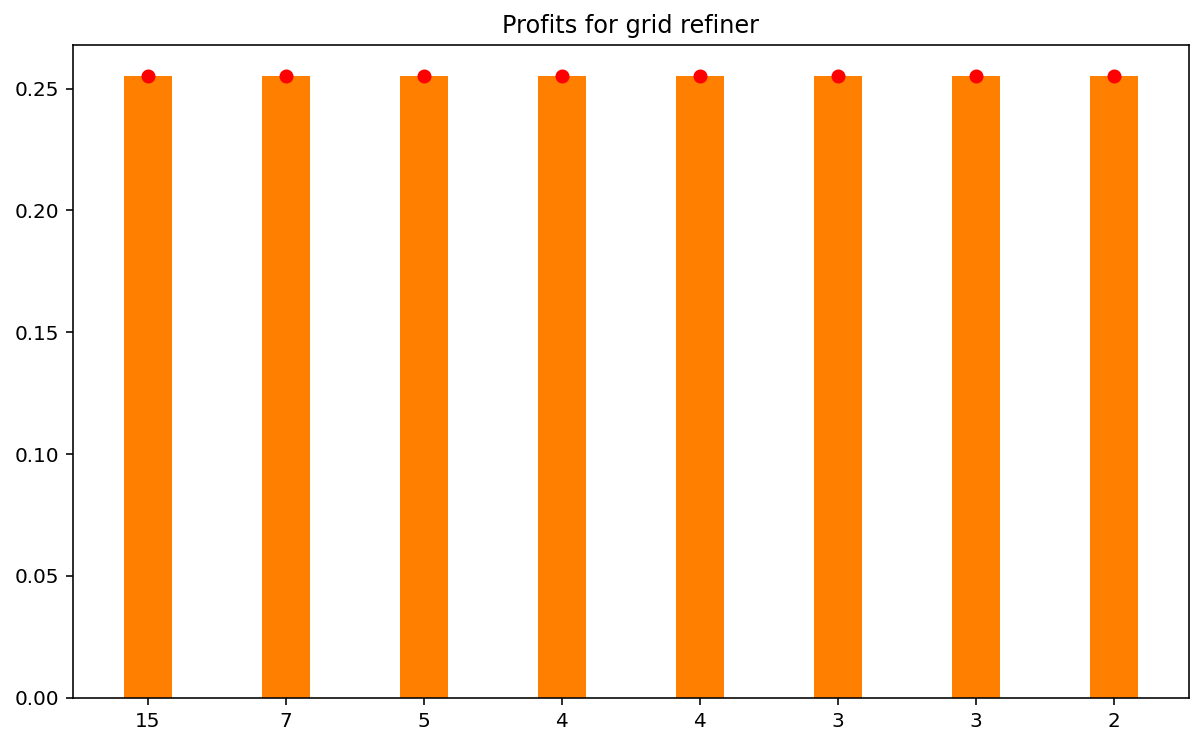

In [33]:
# @title Plot

# @markdown These are the average profits associated with each memory type.
# @markdown Recall that 0.25 is the competitive profit level.
profits_per_memory_type = dict(sorted(profits_per_memory_type.items()))
error_bars_per_memory_type = dict(sorted(error_bars_per_memory_type.items()))

# Combine the data for plotting
bar_width = 0.35
index = np.arange(len(profits_per_memory_type))

plt.figure(figsize=(10, 6))


plt.bar(index + bar_width/2,
        list(profits_per_memory_type.values()),
        bar_width,
        color='#FF8000',
        label='With Errors')
plt.errorbar(index + bar_width/2,
             list(profits_per_memory_type.values()),
             yerr=list(error_bars_per_memory_type.values()),
             fmt="o",
             color="r")



title = MEMORY_TYPE.split('_')
if title[0] == 'grid':
  title = title[0] + ' ' + title[1]
  plt.xticks(index + bar_width / 2, [15, 7, 5, 4, 4, 3, 3, 2])
else:
  title = "type unknown"
  plt.xticks(index + bar_width / 2, list(profits_per_memory_type.keys()))

plt.title(f"Profits for {title}")
plt.show()

In [64]:
#@title Best-Response Functions and other Statistics of Individual Simulations


MEMORY_TYPE = 'grid_refiner' # @param [ "grid_refiner", "thresholds"]
folder = "data_full_memory" # @param [ "data_full_memory", "data_full_memory_long"]
update = 'async' # @param ["async", "sync"]
memory = "8" #@param [1, 2, 3, 4, 5, 6, 7, 8] {allow-input:true}
simulation_number = "5" #@param [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] {allow-input:true}
simulation_number = int(simulation_number) -1

load_memory_types = json.loads(json.load(open('simplicity/simulations/configs/' + MEMORY_TYPE + '.json')))
memory_types = translate_memories(load_memory_types)
memory_dict = [constructor(memory_types[i]) for i in range(len(memory_types))]
# Open and read the JSON file

try:

  filename = 'simplicity/' + folder + '/data_' + update + '_' + MEMORY_TYPE + '_' + memory + '.json'

  f = open(filename)

  data = json.loads(json.load(f))

except:
  print("whoops, missing {}, {}".format(MEMORY_TYPE, i+1))
  pass

memory = int(memory)-1

f = open(filename)

data = json.loads(json.load(f))

try:
  if len(data) <= simulation_number:
    print(f"There are only {len(data)} simulations in the folder {folder} for {memory} memory and {update} update.")
    print(f"Please try with a simulation number up to {len(data)}.")
    raise SystemExit

  try:
    print("This is a representation of states. Prices that are pooled are labeled with the same letter.")
    print("\n")
    state_matrix = state_representation()
    print("\n".join(" ".join(str(item).center(max(4, max(len(str(x)) for r in state_matrix for x in r) + 1)) for item in row) for row in state_matrix))
    print("\n")
  except:
    print("States are too many to represent with letters")
    pass

  print("These are the best responses of player 1 to each state.")
  print("\n")
  brf1 = best_response_matrix(memory_types[memory], memory_dict[memory], 1, data,
                              simulation_number)
  print("\n".join(", ".join(str(item) + " " if len(str(item)) <=3
                            else str(item) for item in key) for key in brf1))
  print("\n")
  print("These are the best responses of player 2 to each state")
  print("\n")
  brf2 = best_response_matrix(memory_types[memory], memory_dict[memory], 2, data,
                              simulation_number)
  print("\n".join(", ".join(str(item) + " " if len(str(item)) <=3
                            else str(item) for item in key) for key in brf2))
  print("\n")

except SystemExit:
  pass

This is a representation of states. Prices that are pooled are labeled with the same letter.


  X    1.43  1.47  1.51  1.55  1.58  1.62  1.66  1.7   1.74  1.78  1.82  1.85  1.89  1.93  1.97
 1.43   A     A     A     A     A     A     A     A     B     B     B     B     B     B     B  
 1.47   A     A     A     A     A     A     A     A     B     B     B     B     B     B     B  
 1.51   A     A     A     A     A     A     A     A     B     B     B     B     B     B     B  
 1.55   A     A     A     A     A     A     A     A     B     B     B     B     B     B     B  
 1.58   A     A     A     A     A     A     A     A     B     B     B     B     B     B     B  
 1.62   A     A     A     A     A     A     A     A     B     B     B     B     B     B     B  
 1.66   A     A     A     A     A     A     A     A     B     B     B     B     B     B     B  
 1.7    A     A     A     A     A     A     A     A     B     B     B     B     B     B     B  
 1.74   C     C     C     C     C     C  